                 created_at  entry_id  field1  field2  field3  field4  field5  \
0 2024-04-06 12:00:27+05:30      1256     163    42.0    33.8    49.0   520.0   
1 2024-04-06 12:01:30+05:30      1257     162    37.0    33.8    49.0   637.0   
2 2024-04-06 12:02:32+05:30      1258     173    47.0    33.7    50.0   679.0   
3 2024-04-06 12:03:34+05:30      1259     168    37.0    33.3    51.0   539.0   
4 2024-04-06 12:04:36+05:30      1260     168    37.0    33.3    52.0   697.0   

   field6  field7  latitude  longitude  elevation  status  
0    18.0    21.0       NaN        NaN        NaN     NaN  
1    36.0     9.0       NaN        NaN        NaN     NaN  
2    42.0     3.0       NaN        NaN        NaN     NaN  
3    21.0     0.0       NaN        NaN        NaN     NaN  
4    45.0     0.0       NaN        NaN        NaN     NaN  


C:\Users\Maruf\AppData\Local\Temp\ipykernel_15196\3249955255.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\Maruf\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maruf\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maruf\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

ValueError: x and y must have same first dimension, but have shapes (268,) and (267,)

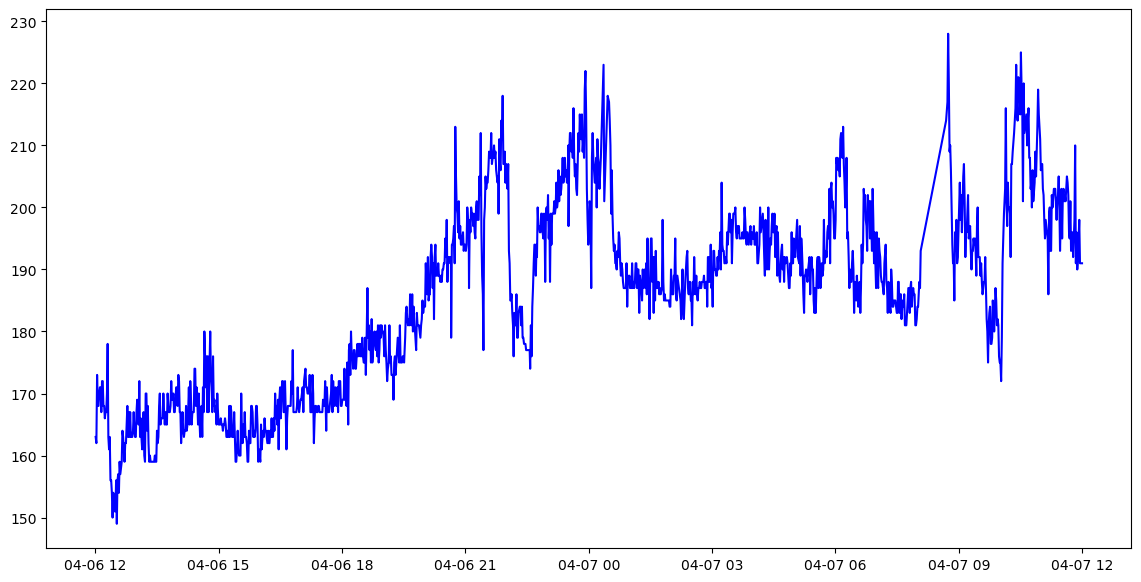

In [42]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error

# Step 1: Preprocessing the Data
# Load the data
data = pd.read_csv('indoor_data.csv', parse_dates=['created_at'])

# Display the first few rows
print(data.head())

# Handle missing values (if any)
data.fillna(method='ffill', inplace=True)

# Convert 'created_at' to datetime and set as index
data.set_index('created_at', inplace=True)

# Assuming 'field1' is the air quality index
data['field1'] = pd.to_numeric(data['field1'], errors='coerce')

# Drop rows with NaN values in 'field1'
data.dropna(subset=['field1'], inplace=True)

# Step 2: Train ARIMA Model
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data['field1'][:train_size], data['field1'][train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(5, 1, 0))  # Adjust order as necessary
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))
test['predictions'] = predictions

# Step 3: Anomaly Detection
# Using Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05)  # Adjust contamination as necessary
data['anomaly'] = iso_forest.fit_predict(data[['field1']])

# Step 4: Compare Results
# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['field1'], label='Air Quality Index', color='blue')
plt.plot(test.index, test['predictions'], label='Predictions', color='orange')
plt.scatter(data[data['anomaly'] == -1].index, data[data['anomaly'] == -1]['field1'], color='red', label='Anomalies')
plt.title('Air Quality Index Predictions with Anomalies')
plt.xlabel('Date')
plt.ylabel('Air Quality Index')
plt.legend()
plt.show()

# Evaluate performance
mse_before = mean_squared_error(test, test['predictions'])
print(f'Mean Squared Error before anomaly detection: {mse_before}')

# Optionally, you can also evaluate the model after removing anomalies
cleaned_data = data[data['anomaly'] != -1]
train_cleaned, test_cleaned = cleaned_data['field1'][:train_size], cleaned_data['field1'][train_size:]

# Fit ARIMA model again on cleaned data
model_cleaned = ARIMA(train_cleaned, order=(5, 1, 0))
model_fit_cleaned = model_cleaned.fit()
predictions_cleaned = model_fit_cleaned.forecast(steps=len(test_cleaned))

# Evaluate performance after anomaly detection
mse_after = mean_squared_error(test_cleaned, predictions_cleaned)
print(f'Mean Squared Error after anomaly detection: {mse_after}')

In [34]:
!pip install pmdarima
!pip install statsmodels